<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/OptimizacionHyp/BayesianOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Bayesian Optimization for Hyperparameter Tuning

- Bayesian Optimization (BO) is a probabilistic model-based optimization technique especially useful when your objective function (like model accuracy or loss) is expensive to evaluate, as in training machine learning models with different hyperparameters.

## What is Hyperparameter Tuning?

- In machine learning, hyperparameters (e.g., learning rate, number of trees, regularization strength) need to be set before training begins. Tuning them effectively can greatly improve model performance.

## Traditional methods:

- **Grid Search**: tries every combination — slow and inefficient.

- **Random Search**: better, but still wasteful.

- **Bayesian Optimization**: smart and sample-efficient.

![gridrandom](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*lu62RCEko0VYe-YZ)


## How Bayesian Optimization Works?

- **Model the Objective Function**: BO builds a surrogate model, usually a Gaussian Process (GP), Tree-structured Parzen Estimator (TPE), or Tree-structured Parzen Estimator (ATPE) to approximate the real objective function (like validation loss) using a Sequential Model-Based Global Optimization (SMBO).

- **Use an Acquisition Function**: The acquisition function (e.g., Expected Improvement, Probability of Improvement, Upper Confidence Bound) balances exploration vs. exploitation and suggests the next point to evaluate.

- **Iteratively Update**: After evaluating the true objective at the suggested point, BO updates the surrogate and repeats.

![bayes](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/OptimizacionHyp/bayesianOptHyp.jpeg?raw=1)



## Common Python Tools

- Optuna: https://optuna.org/

- scikit-optimize: https://scikit-optimize.github.io/stable/

- Hyperopt: https://hyperopt.github.io/hyperopt/

- Ray Tune: https://docs.ray.io/en/latest/tune/index.html







# Bayesian Optimization using Gaussian Process

In GP-based Bayesian Optimization, the objective function is modeled as a Gaussian Process:

1. Surrogate model:

Given observations $\mathfrak{D}=\{\mathbf{x}_n,y_n\}_{n=1}^N$
 , the GP defines a distribution over functions:

 $$f(\mathbf{x})\sim GP(\mu(\mathbf{x}), \kappa(\mathbf{x},\mathbf{x}'))$$

where $\mu(\mathbf{x})$ is the mean function (usually 0) and $\kappa(\mathbf{x},\mathbf{x}')$ is a kernel.

 2. Posterior mean and variance:

For a new point $\mathbf{x}_*$, the GP posterior is (see [GP notes](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/2_Kernels_GaussianProcess/2_GaussianProcess_Regression.ipynb)):



$\mu(\mathbf{x}_*)=\mathbf{k}_*^\top\left(\mathbf{K}+\sigma_\epsilon^2\mathbf{I}\right)^{-1}\mathbf{y}$

$\sigma^2(\mathbf{x}_*)=\kappa(\mathbf{x}_*,\mathbf{x}_*)-\mathbf{k}_*^\top\left(\mathbf{K}+\sigma_\epsilon^2\mathbf{I}\right)^{-1}\mathbf{k}_*$

3. Acquisition Function (Expected Improvement - EI):

- To decide where to sample a balance between exploitation and exploration is used.

- Expected Improvement (EI) is defined as:

$$ EI(\mathbf{𝑥})=
\mathbb{𝐸}[\text{max}(𝑓_{\text{best}}−𝑓(\mathbf{𝑥}),0)] $$


- Given that $f(\mathbf{x})\sim N(\mu(\mathbf{x}),\sigma^2(\mathbf{x}))$, EI can be computed in closed form:

- Let:

$$f_{\text{best}}= \text{min}(y_1,y_2,\dots,y_n)$$

$$Z = \frac{f_{\text{best}}-\mu(\mathbf{x})}{\sigma(\mathbf{x})}$$

- Then:

$$ EI(\mathbf{𝑥})=
(𝑓_{\text{best}}−\mu(\mathbf{x}))\phi(Z)+\sigma(\mathbf{x})\varphi(Z) $$

where:

$\phi(\cdot)$: CDF of standard normal

\varphi(\cdot): PDF of standard normal

- This expression increases in regions of high uncertainty ($\sigma$) and near the current best value ($𝑓_{\text{best}}$).


4. Summary in Context of Optuna with GP:

- In your Optuna example using optuna.samplers.GPSampler(), the following happens internally:

- A GP model (e.g., with Matern or RBF kernel) is trained on the past trials.

- The posterior mean and variance are computed for candidate points.

- An acquisition function like EI or UCB is maximized to suggest the next trial.

- This balances sampling promising hyperparameters and exploring new regions.


## Pseudocode

for each trial:

    fit GP to (X, y)
  
    select x_new = argmax_x acquisition_function(x; GP)
  
    evaluate f(x_new)



# Matern Kernel (Commonly fixed for Optuna + GP)

The Matérn kernel is defined as:

$$
\kappa_{\nu}(r) = \sigma^2 \cdot \frac{2^{1-\nu}}{\Gamma(\nu)} \left( \frac{\sqrt{2\nu} r}{\ell} \right)^{\nu} K_{\nu} \left( \frac{\sqrt{2\nu} r}{\ell} \right)
$$

where:

  - $ r = \| \mathbf{x} - \mathbf{x}' \| $ is the Euclidean distance between input vectors.
  - $ \nu > 0 $ is the smoothness hyper-hyper parameter,
  - $ \ell > 0 $ is the length-scale,
  - $ \sigma^2 $ is the signal variance,
  - $ \Gamma(\cdot) $ is the Gamma function,
  - $ K_{\nu}(\cdot) $ is the modified Bessel function of the second kind.


- $\nu=1/2$ Exponential kernel (also known as Ornstein-Uhlenbeck kernel):

$$\kappa_{1/2}(r) = \sigma^2 \exp\left( -\frac{r}{\ell} \right)$$

- $\nu = 3/2$:

$$ \kappa_{3/2}(r) = \sigma^2 \left( 1 + \frac{\sqrt{3} r}{\ell} \right) \exp\left( -\frac{\sqrt{3} r}{\ell} \right)$$

- $\nu=5/2$:

$$\kappa_{5/2}(r) = \sigma^2 \left( 1 + \frac{\sqrt{5} r}{\ell} + \frac{5 r^2}{3 \ell^2} \right) \exp\left( -\frac{\sqrt{5} r}{\ell} \right)$$

| $\nu$ Value              | Smoothness        | Differentiability of GP samples     | Notes                                                 |
| ------------------------ | ----------------- | ------------------------------- | ----------------------------------------------------- |
| $\tfrac{1}{2}$              | Rough             | Not differentiable              | Exponential kernel (Ornstein-Uhlenbeck process)       |
| $\tfrac{3}{2}$              | Moderately smooth | Once differentiable             | Captures some roughness                               |
| $\tfrac{5}{2}$              | Smooth            | Twice differentiable            | More regular functions                                |
| $\rightarrow \infty$ | Infinitely smooth | Infinitely differentiable       | Converges to the **squared exponential (RBF)** kernel |




# Example with Optuna and Scikit-Learn

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 9.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_friedman1
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import loguniform
from scipy.interpolate import griddata
import optuna
from optuna.samplers import GPSampler

# toy data
X, y = make_friedman1(n_samples=300, n_features=5, noise=1.0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# hyperparameters range
alphas = np.logspace(-3, 3, 20)
gammas = np.logspace(-3, 3, 20)

# Grid Search
param_grid = {'alpha': alphas, 'gamma': gammas}
grid_search = GridSearchCV(KernelRidge(kernel='rbf'), param_grid, scoring='neg_mean_squared_error', cv=3) #maximizes
grid_search.fit(X_train, y_train)
grid_results = [(params['alpha'], params['gamma'], -score)
                for params, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score'])]

# Random Search
param_dist = {'alpha': loguniform(1e-3, 1e3), 'gamma': loguniform(1e-3, 1e3)}
random_search = RandomizedSearchCV(KernelRidge(kernel='rbf'), param_distributions=param_dist,
                                   n_iter=40, scoring='neg_mean_squared_error', cv=3, random_state=42)
random_search.fit(X_train, y_train)
random_results = [(params['alpha'], params['gamma'], -score)
                  for params, score in zip(random_search.cv_results_['params'], random_search.cv_results_['mean_test_score'])]

# Bayesian Optimization
bayes_results = []

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-3, 1e3, log=True)
    gamma = trial.suggest_float('gamma', 1e-3, 1e3, log=True)
    model = KernelRidge(kernel='rbf', alpha=alpha, gamma=gamma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    error = mean_squared_error(y_test, y_pred)
    bayes_results.append((alpha, gamma, error, trial.number))
    return error

study = optuna.create_study(direction='minimize',sampler=GPSampler())
study.optimize(objective, n_trials=40)

# plots
def plot_with_contour(results, title, cmap='viridis', use_iteration=False):
    alphas, gammas, values, iterations = [], [], [], []

    for i, res in enumerate(results):
        alphas.append(res[0])
        gammas.append(res[1])
        values.append(res[2])
        iterations.append(res[3] if use_iteration else i)

    # Malla logarítmica
    xi = np.logspace(np.log10(min(alphas)), np.log10(max(alphas)), 100)
    yi = np.logspace(np.log10(min(gammas)), np.log10(max(gammas)), 100)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((alphas, gammas), values, (xi, yi), method='cubic')

    plt.figure(figsize=(7, 6))
    contour = plt.contourf(xi, yi, zi, levels=20, cmap=cmap, alpha=0.4)
    plt.colorbar(contour, label='MSE')
    scatter = plt.scatter(alphas, gammas, c=iterations, cmap='gray', edgecolor='k')
    plt.xscale('log')
    plt.yscale('log')
    plt.colorbar(scatter, label='Iteration Number')
    plt.xlabel('alpha')
    plt.ylabel('gamma')
    plt.title(title)
    plt.grid(True, which='both', ls='--')
    plt.show()

# iteration index
grid_results_with_iter = [(a, g, e, i) for i, (a, g, e) in enumerate(grid_results)]
random_results_with_iter = [(a, g, e, i) for i, (a, g, e) in enumerate(random_results)]




<ipython-input-2-b980a0248bf6>:48: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = optuna.create_study(direction='minimize',sampler=GPSampler())
[I 2025-05-05 03:52:15,754] A new study created in memory with name: no-name-34308dfb-bbba-43c1-a3ba-ff40a804fb58
[I 2025-05-05 03:52:15,939] Trial 0 finished with value: 8.63612703395927 and parameters: {'alpha': 5.10660527823002, 'gamma': 0.4415538172563842}. Best is trial 0 with value: 8.63612703395927.
[I 2025-05-05 03:52:15,952] Trial 1 finished with value: 84.62443635907606 and parameters: {'alpha': 55.822392946594086, 'gamma': 2.262282789139114}. Best is trial 0 with value: 8.63612703395927.
[I 2025-05-05 03:52:15,960] Trial 2 finished with value: 13.729170952474384 and parameters: {'alpha': 0.011565921314957189, 'gamma': 10.108441707310577}. Best is trial 0 with value: 8.63612703395927.
[I 2025-05-05 03:52:16,144] Trial 3 finished with value: 253.25509000736722 a

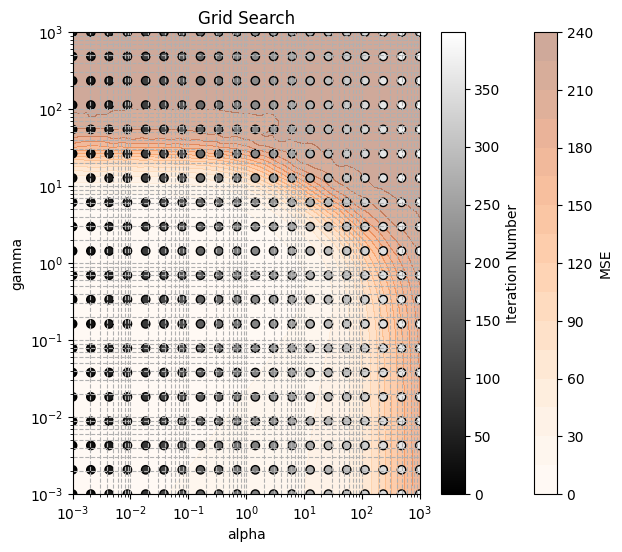

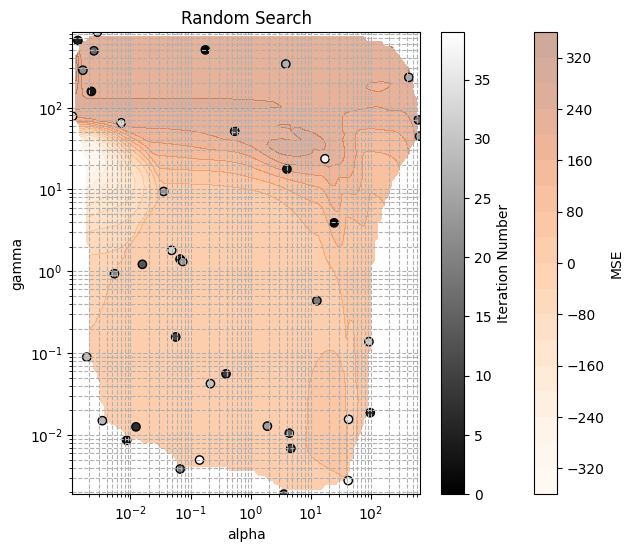

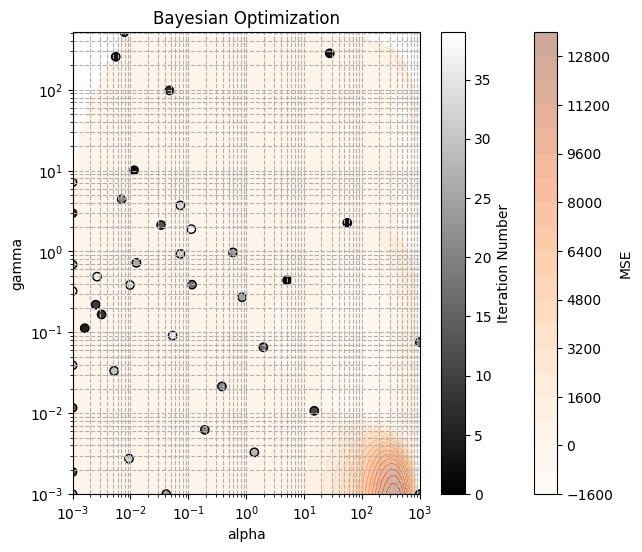

 Best Grid Search Result:
  alpha = 0.001000
  gamma = 0.335982
  MSE   = 1.608362

 Best Random Search Result:
  alpha = 0.005398
  gamma = 0.935538
  MSE   = 1.669702

 Best Bayesian Optimization Result:
  alpha = 0.001000
  gamma = 0.323958
  MSE   = 1.348943


In [3]:
# plots
plot_with_contour(grid_results_with_iter, 'Grid Search', cmap='Oranges')
plot_with_contour(random_results_with_iter, 'Random Search', cmap='Oranges')
plot_with_contour(bayes_results, 'Bayesian Optimization', use_iteration=True, cmap='Oranges')

# --- best hyperparameters
best_grid_index = np.argmin([res[2] for res in grid_results])
best_grid = grid_results[best_grid_index]
print(" Best Grid Search Result:")
print(f"  alpha = {best_grid[0]:.6f}")
print(f"  gamma = {best_grid[1]:.6f}")
print(f"  MSE   = {best_grid[2]:.6f}")

best_random_index = np.argmin([res[2] for res in random_results])
best_random = random_results[best_random_index]
print("\n Best Random Search Result:")
print(f"  alpha = {best_random[0]:.6f}")
print(f"  gamma = {best_random[1]:.6f}")
print(f"  MSE   = {best_random[2]:.6f}")

best_bayes_index = np.argmin([res[2] for res in bayes_results])
best_bayes = bayes_results[best_bayes_index]
print("\n Best Bayesian Optimization Result:")
print(f"  alpha = {best_bayes[0]:.6f}")
print(f"  gamma = {best_bayes[1]:.6f}")
print(f"  MSE   = {best_bayes[2]:.6f}")

# Optuna visualizations

In [4]:
from optuna.visualization import (plot_optimization_history,plot_param_importances, plot_parallel_coordinate,plot_contour)


In [5]:

plot_optimization_history(study)

In [6]:
plot_param_importances(study)

In [7]:
print("\n Best Bayesian Optimization Result:")
print(f"  alpha = {best_bayes[0]:.6f}")
print(f"  gamma = {best_bayes[1]:.6f}")
print(f"  MSE   = {best_bayes[2]:.6f}")

plot_contour(study, params=["gamma", "alpha"])


 Best Bayesian Optimization Result:
  alpha = 0.001000
  gamma = 0.323958
  MSE   = 1.348943


In [8]:
plot_parallel_coordinate(study)